# DSCI 100 - Final Project Report
**Project Members**: Adam, Praewa, Renai

# Introduction

Our project utilizes data about individuals volunteering to play on a Minecraft server. The original objective or project of the dataset is to capture player behaviours that help with training and developing an advanced AI player deployed in a virtual world like Minecraft. The central goal of the AI is to comprehend speech and respond and act like an ordinary player (PLAI, 2024). 
Two datasets related to the project were provided, `players.csv` and `sessions.csv`, to conduct exploratory analysis and make predictions.

The players dataset contains 196 observations and 7 variables that capture player demographics, experience levels, and newsletter subscription status. The variables include:

- `hashed_email` (character): Player email encrypted as codes, serving as unique identifiers.
- `experience` (character): Player’s game experience level (Pro, Veteran, Amateur, Regular).
- `subscribe` (logical): Player’s subscription status to a game-related newsletter (TRUE or FALSE).
- `played_hours` (double): Total hours played on the Minecraft server.
- `name` (character): Player’s first name.
- `gender` (character): Player's gender.
- `age` (double): Player’s age in years.

, highlighting the characteristics exhibited by different player types. However, issues such as missing values in age are present in this dataset. 

The sessions dataset includes 1,535 observations and 5 variables that capture details about individual sessions in the Minecraft server, which helps to indicate player engagement patterns over time. The variables include:

- `hashed_email` (character): Player email encrypted as codes, serving as unique identifiers.
- `start_time` (character): Start time of the session (in date-time format).
- `end_time` (character): End time of the session (in date-time format).
- `original_start_time` (double): Unix timestamp of `start_time`.
- `original_end_time` (double): Unix timestamp of `end_time`.

, where data cleaning for this dataset is necessary. Specifically, variables like `original_start_time` and `original_end_time` are presented in Unix time, which is difficult to interpret as they suggest seconds elapsed after January 1st, 1970. Omitting the two variables and using the `start_time` and `end_time` variables instead would be preferred in the context of our research.

**Our question asks**: Can players' age, number of sessions played, average session played hours, and total hours played predict whether they are subscribed to a game-related newsletter? Understanding the role of our two data sets is vital in answering this predictive question.

# Data Analysis Process

The data analysis process is conducted as follows:

**Loading data**

We began by loading the necessary R packages and reading the two datasets: `players.csv` and `sessions.csv`. Column names are cleaned using `clean_names()` for easier reference of columns. The `head()` function is also used to only display small sections and verify the format of the datasets.

**Cleaning**

After reading the datasets, only the necessary columns for our analysis are selected:
- `players.csv`: Selected `hashed_email`, `subscribe`, `played_hours`, and `age`.
- `sessions.csv`: Selected `hashed_email`, `start_time`, and `end_time`, and then data is tidied, i.e., separated `start_time` and`end_time` into year, month, day, hour and minute variables and converted to numeric using `as.numeric()`.

**Wrangling**

Since we plan to use variables like the number of sessions played (`sessions_played`) and average session played hours (`avg_session_hours`) from each player not directly provided by the datasets as predictors, they will be derived from `sessions.csv` and combined with `players.csv` for a complete dataset.

Firstly, hours played in each session are calculated using functions from the `lubridate` R package:

- `make_datetime()` combines the start and end time variables as calculable `lubridate` time variables.
- `difftime()` calculates differences in hours between the start and end session time, creating hours played for each session (`time_elapsed`).

To ensure variables are for each player instead of each session, we group by `hashed_email` and then use:

- `n()` to calculate `sessions_played` for each player.
- `mean(time_elapsed)` to calculate `avg_session_hours` for each player.

The new variables from `sessions.csv` are then joined with `players.csv` using `hashed_email` as the identifier:

- `full_join()` ensures players are not lost during the merge.
- `join_by(hashed_email)` ensures the data are joined by a unique identifier that assigns values of variables from both datasets to the correct player.

Finally, the merged dataset is then cleaned:

- For players who never played a session, we used `replace_na()` to replace the missing values of `avg_session_hours` and `sessions_played` with 0.
- The `subscribe` variable is converted to a categorical variable with interpretable labels (`subscription_status`). 
- The `select` function is used to keep only the necessary columns for $K$-NN classification.
- Observations with missing values in age (only 2) are filtered out.

**Summary**

For exploratory data analysis (EDA) summaries, we produced two tables:

1. A class summary table that displays the number of observations and the % of total observations each class shares.
2. A difference in means table that displays the mean values of all predictors for each class.

, where the goal is to draw vital differences between classes (subscribers and non-subscribers).

**Visualizations**

For EDA visualizations, we produced two plots:

1. A pair plot of the complete data set, which allows analyzing distributions of a single variable and relationships between two variables.	
    - `ggpairs()` produces this matrix of scatter plots for each pair of numeric variables and histograms for individual variable distributions, all colour-coded and separated by subscription status.
2. A bar chart emphasizing the distribution of game-related newsletter subscription statuses.
    - Bars on the x-axis are separated and coloured by levels of `subscription_status`, while the number of players is plotted on the y-axis.

**Data Analysis**

We decided to use the $K$-Nearest Neighbors ($K$-NN) classification model to predict game-related newsletter subscription statuses with the predictors in our complete dataset. The classification process using `tidymodels` is as follows:

1. `set.seed(999)` is applied to ensure reproducibility.
2. Select the predictor variables and response variable (`subscription_status`):
    - Columns are extracted from our complete dataset into a new data frame called `mc_data`, ensuring any future additions in the complete dataset do not impact the variables chosen for classification.
3. `mc_data` is split into 75% training and 25% testing with stratified sampling ensuring the class distribution of subscribers vs. non-subscribers is preserved.
4. A recipe is created with these conditions:
    - Due to class imbalance, `step_upsample()` is used to over-sample non-subscribers. `over_ratio = 1` ensures that each class has an equal number of observations.
    - `step_scale()` and `step_center()` are used to center and scale all predictors to a mean of 0 and a standard deviation of 1, ensuring comparable scales and no individual predictor dominating the classification. 
5. $K$ is tuned using cross-validation:
    - 5-fold cross-validation and a grid of $k$ from 1 to 30 are used to tune the model.
    - For the tuning model specification, we use the `kknn` engine, `weight_func = “rectangular”` for equal weight for neighbors, and `neighbors = tune()` to tune for $K$. 
    - A workflow is then created by combining the recipe, model specification, `tune_grid()`, and `collect_metrics()` to tune for $K$ values and collect the estimated accuracy for each $K$. 
    - A line plot of estimated accuracy vs. the number of neighbors is produced where a $K$ of 5 is chosen because it has a high estimated accuracy and at $K=5$, the estimated accuracies at $K-1$ and $K+1$ do not exhibit significant differences.
6. Evaluating the $K$-NN model using the testing data: 
    - Using the chosen $K$ of 5, a new workflow (`mc_fit`) is created that combines the same recipe and a new model specification with `neighbors = 5`, and fits the training data.
    - Use the fitted model to predict the testing data and then bind those predictions to the testing data. 
    - Accuracy is collected using `metrics()` to evaluate how accurate all predictions are.
    - A confusion matrix is generated to evaluate prediction accuracy for each class. The matrix layout shows: 
        1. 32 True Positives (correctly predicted as `Subscribed`)
        2. 7 False Positives (predicted `Subscribed`, actually `Not Subscribed`)
        3. 4 False Negatives (predicted `Not Subscribed`, actually `Subscribed`)
        4. 6 True Negatives (correctly predicted as `Not Subscribed`)
    - Precision and recall for each class are then calculated using the above values to analyze differences in the metrics for both classes.
        - A bar chart faceted by metric, with bars on the x-axis separated and coloured by levels of `subscription_status` and values of metrics plotted on the y-axis is also produced to better highlight those differences.


# Loading, Cleaning, and Wrangling Datasets

In [1]:
# Loading packages

library(tidyverse)
library(repr)
library(janitor)
library(lubridate)
library(tidymodels)
library(themis)
library(GGally)

set.seed(2025)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ──────

In [2]:
# Loading players.csv and sessions.csv

sessions_url<-"https://raw.githubusercontent.com/adamcheng7/DSCI-100-Final-Project-Report/refs/heads/main/data/sessions.csv"
players_url<-"https://raw.githubusercontent.com/adamcheng7/DSCI-100-Final-Project-Report/refs/heads/main/data/players.csv"

sessions_data<-read_csv(sessions_url)|>clean_names()
players_data<-read_csv(players_url)|>clean_names()

head(sessions_data)
head(players_data)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashed_email,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
# Cleaning players.csv

players_cleaned<-players_data|>
    select(hashed_email,subscribe,played_hours,age)

# Cleaning sessions.csv

## Separating start_time into year, month, day, hour, and minute
sessions_select<-sessions_data|>
    select(hashed_email,start_time,end_time)

sessions_tidy<-sessions_select|>
    separate(start_time,into=c("start_day","start_month","start_year_time"),sep="/")|>
    separate(start_year_time,into=c("start_year","start_time"),sep=" ")|>
    separate(start_time,into=c("start_hour","start_minute"),sep=":")

## Separating end_time into year, month, day, hour, and minute
sessions_tidy<-sessions_tidy|>
    separate(end_time,into=c("end_day","end_month","end_year_time"),sep="/")|>
    separate(end_year_time,into=c("end_year","end_time"),sep=" ")|>
    separate(end_time,into=c("end_hour","end_minute"),sep=":")

## Rearranging columns and converting time variables to numeric
sessions_cleaned<-sessions_tidy|>
    select(hashed_email,
           start_year,start_month,start_day,start_hour,start_minute,
           end_year,end_month,end_day,end_hour,end_minute
          )|>
    mutate(across(start_year:end_minute,as.numeric))

head(sessions_cleaned)
head(players_cleaned)

hashed_email,start_year,start_month,start_day,start_hour,start_minute,end_year,end_month,end_day,end_hour,end_minute
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024,6,30,18,12,2024,6,30,18,24
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024,6,17,23,33,2024,6,17,23,46
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024,7,25,17,34,2024,7,25,17,57
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024,7,25,3,22,2024,7,25,3,58
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024,5,25,16,1,2024,5,25,16,12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024,6,23,15,8,2024,6,23,17,10


hashed_email,subscribe,played_hours,age
<chr>,<lgl>,<dbl>,<dbl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,TRUE,30.3,9
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,TRUE,3.8,17
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,FALSE,0.0,17
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,TRUE,0.7,21
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,TRUE,0.1,21
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,TRUE,0.0,17


In [4]:
# Wrangling datasets to complete format

merged_data <- sessions_cleaned |>
    mutate(start_datetime = make_datetime(start_year, start_month, start_day, start_hour, start_minute),
           end_datetime = make_datetime(end_year, end_month, end_day, end_hour, end_minute),
           time_elapsed = as.numeric(difftime(end_datetime, start_datetime, units = "hours"))
          ) |>
    group_by(hashed_email) |>
    summarize(sessions_played = n(),
              avg_session_hours = round(mean(time_elapsed, na.rm = TRUE), 2)
             ) |>
    full_join(players_cleaned, join_by(hashed_email))

complete_data <- merged_data |>
    mutate(sessions_played = replace_na(sessions_played, 0),
           avg_session_hours = replace_na(avg_session_hours, 0),
           subscription_status = factor(subscribe, 
                                         levels = c(TRUE, FALSE), 
                                         labels = c("Subscribed", "Not Subscribed"))
          ) |>
    select(-subscribe, -hashed_email) |> # Removing identifier columns and the old subscribe variable
    filter(!is.na(age))  # This line removes the two observations that had missing values in 'age'

head(complete_data)

sessions_played,avg_session_hours,played_hours,age,subscription_status
<int>,<dbl>,<dbl>,<dbl>,<fct>
2,0.88,1.5,20,Subscribed
1,0.50,0.4,21,Not Subscribed
1,0.18,0.1,17,Subscribed
13,0.54,5.6,17,Subscribed
2,0.58,1.0,17,Subscribed
1,0.17,0.1,19,Not Subscribed


# Exploratory Data Analysis

In [5]:
# Class summary table

subscription_proportions<-complete_data|>
    mutate(`Subscription Status`=subscription_status)|>
    group_by(`Subscription Status`)|>
    summarize(`Number of Observations` = n())|>
    mutate(`% of Total Observations` = round(100*`Number of Observations`/nrow(complete_data),2))

subscription_proportions

Subscription Status,Number of Observations,% of Total Observations
<fct>,<int>,<dbl>
Subscribed,142,73.2
Not Subscribed,52,26.8


There is a significant class imbalance, as 73.2% of total observations are subscribers of game-related newsletters while 26.8% are non-subscribers. A biased sample is likely the cause of this class imbalance because the data is collected from volunteers rather than a random sample, meaning game-enthusiasts (higher likelihood of being a subscriber) tend to sign up for these game-related activities more often than non-game-enthusiasts. Though this is not an indicator of poor data, the lack of non-subscriber data can impede the performance of the K-NN classification model in accurately predicting non-subscribers.

In [6]:
# Difference in means table for predictor values of each class

predictors_summary_statistics<-complete_data|>
    mutate(`Subscription Status`=subscription_status)|>
    group_by(`Subscription Status`)|>
    summarize(
        `Mean Age`=mean(age,na.rm=TRUE),
        `Mean Average Session Hours`=mean(avg_session_hours,na.rm=TRUE),
        `Mean Played Hours`=mean(played_hours,na.rm=TRUE),
        `Mean Sessions Played`=mean(sessions_played,na.rm=TRUE)
    )|>
    mutate(across(where(is.numeric),~round(., 2)))

predictors_summary_statistics

Subscription Status,Mean Age,Mean Average Session Hours,Mean Played Hours,Mean Sessions Played
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Subscribed,19.62,0.37,7.88,10.07
Not Subscribed,22.98,0.28,0.50,1.98


This difference in means table shows that subscribers, on average, exhibit higher values for all predictors except age, with significant differences in mean played hours and mean sessions played, suggesting they may be better predictors in drawing the vital distinctions between classes than mean age and average session hours as they exhibit negligible differences.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


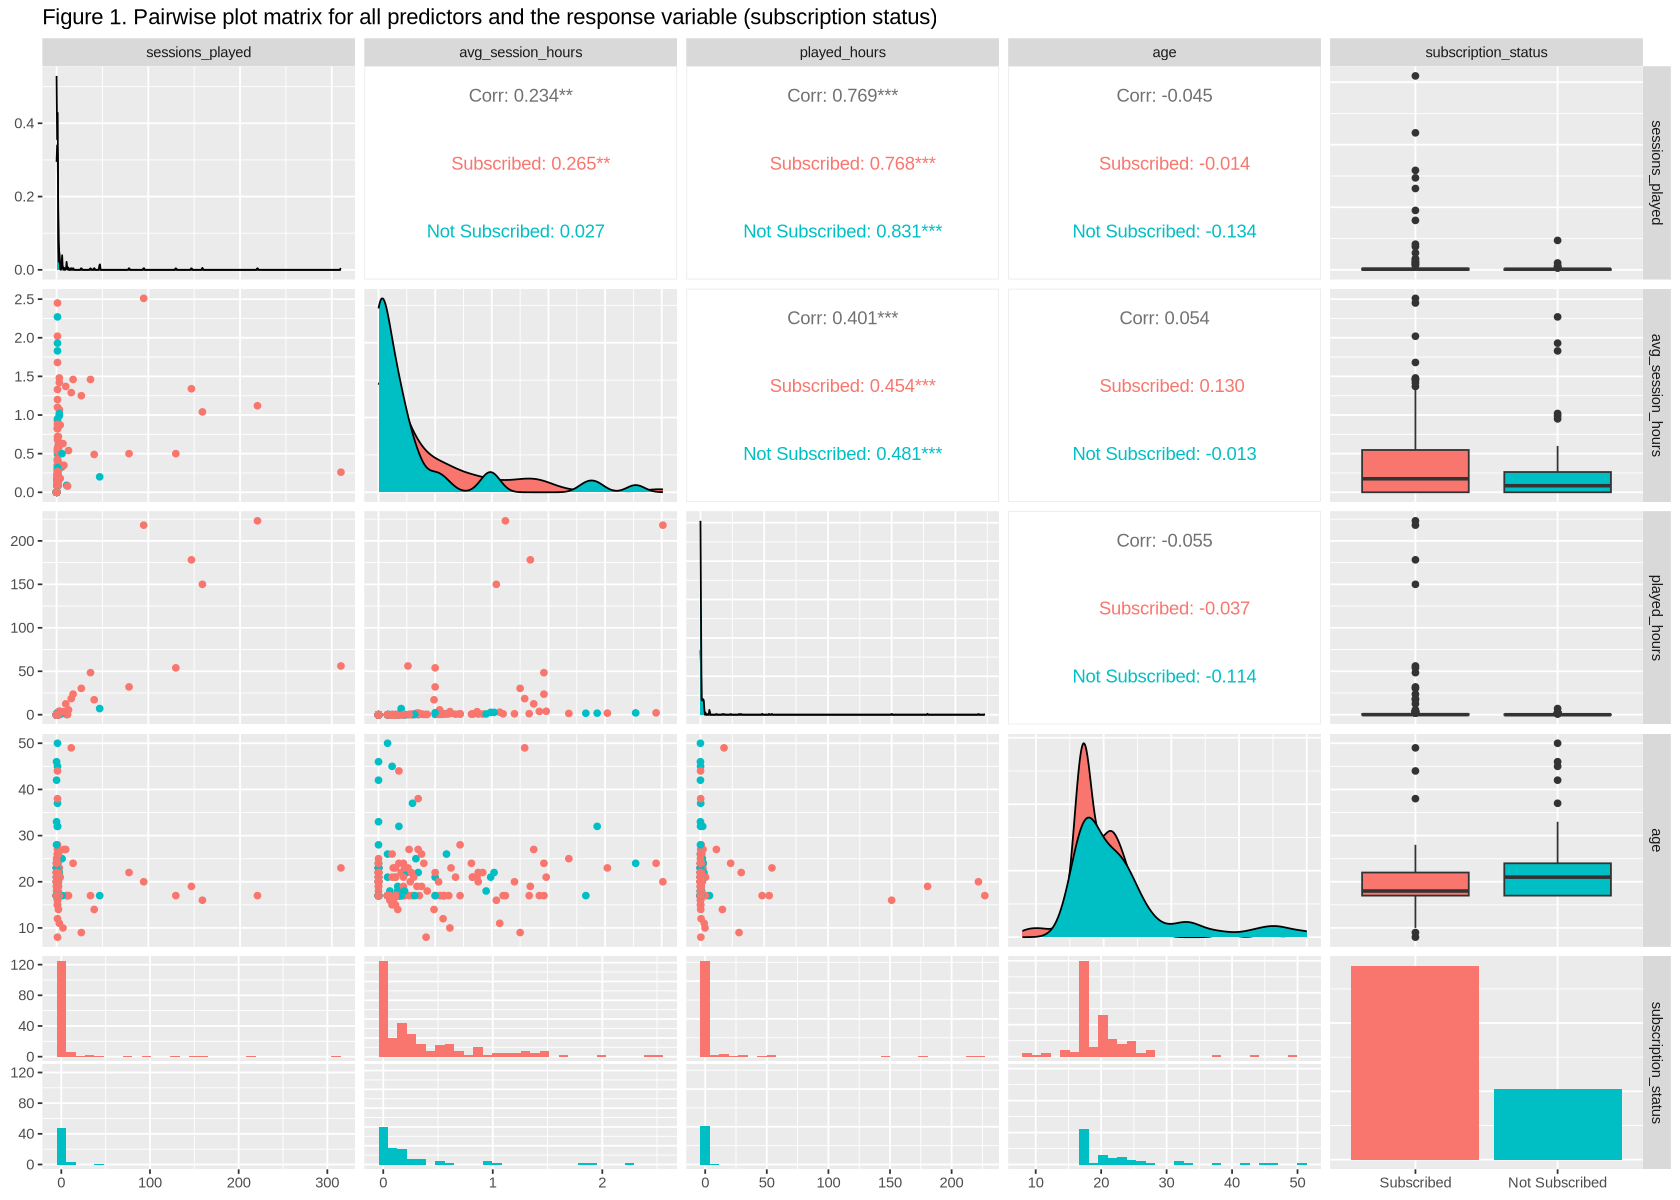

In [7]:
options(repr.plot.height=10,repr.plot.width=14)

# Pair plot for all predictors and the response variable (subscription status)
ggpairs(complete_data,mapping=aes(color=subscription_status))+
labs(title="Figure 1. Pairwise plot matrix for all predictors and the response variable (subscription status)")

Figure 1 indicates that all predictors lack variability, especially `played_hours` and `sessions_played`. All histograms and kernel density estimations suggest all distributions are skewed to the right, with significant concentrations in lower values. The underrepresentation of players with higher predictor values may present problems in the prediction accuracy of certain classes. Scatterplots also emphasize the class imbalance with data points dominated by subscribers.

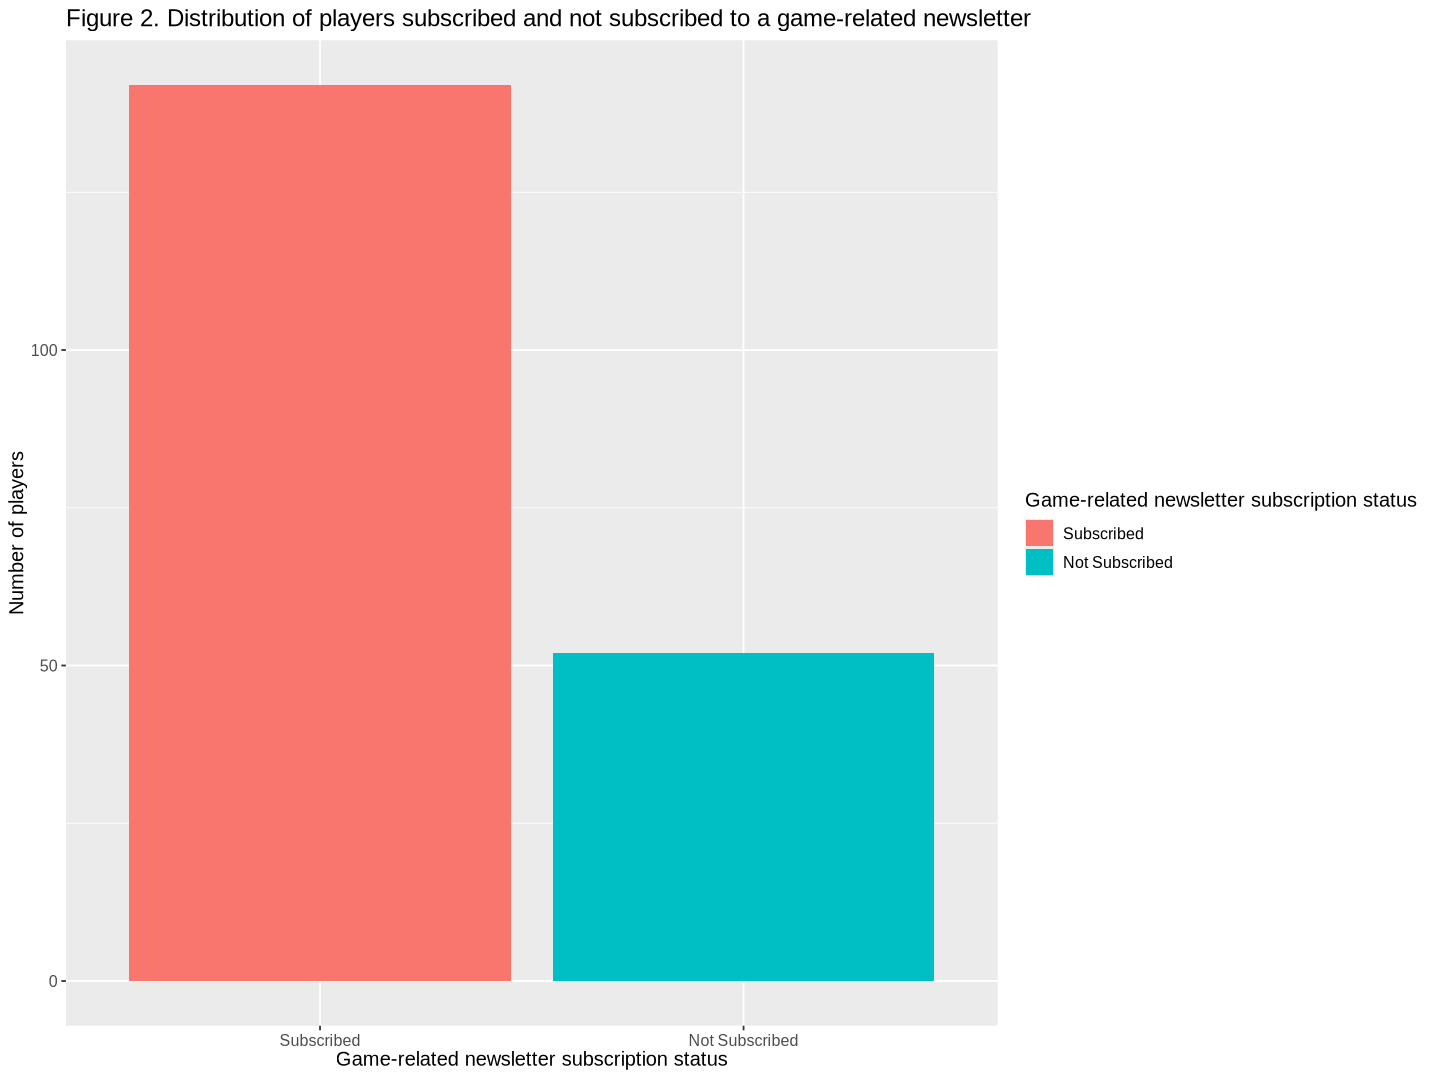

In [8]:
options(repr.plot.width=12,repr.plot.height=9)

# Class balance diagnosis bar chart
class_balance<-complete_data|>
    ggplot(aes(x=subscription_status,fill=subscription_status))+
    geom_bar()+
    labs(
        x="Game-related newsletter subscription status",
        y="Number of players",
        title="Figure 2. Distribution of players subscribed and not subscribed to a game-related newsletter",
        fill="Game-related newsletter subscription status"
        )+
    theme(text=element_text(size=12))

class_balance

Figure 2 further highlights the class imbalance, suggesting the upsampling of non-subscribers is required to prevent subscribers from dominating the K-NN classification.

# Performing $K$-NN Classification

In [9]:
# Ensuring reproducibility
set.seed(999)

# Tuning K-NN classification model

# Selecting predictors. Change to alter predictor combinations if needed
predictors<-c("avg_session_hours", "sessions_played", "played_hours", "age")
mc_data<-complete_data|>
    select(all_of(predictors),subscription_status)

# Splitting dataset
mc_split <- initial_split(mc_data,prop=0.75,strata=subscription_status)
mc_train <- training(mc_split)
mc_test <- testing(mc_split)

# Creating recipe. Upsampling non-subscribers up to 1:1 ratio due to significant class imbalance
mc_recipe <- recipe(subscription_status~.,data=mc_train)|>
    step_upsample(subscription_status, over_ratio = 1, skip = TRUE) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())

# 5-fold cross validation and selecting range of neighbors (1-30)
mc_vfold<-vfold_cv(mc_train,v=5,strata=subscription_status)
mc_neighbors<-tibble(neighbors=seq(from=1,to=30,by=1))

# Tuning knn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Producing estimated accuracy metric
mc_tune<- workflow()|>
    add_model(knn_spec)|>
    add_recipe(mc_recipe)|>
    tune_grid(resamples=mc_vfold,grid=mc_neighbors)|>
    collect_metrics()|>
    filter(.metric=="accuracy")

head(mc_tune)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7033005,5,0.03567788,Preprocessor1_Model01
2,accuracy,binary,0.6961741,5,0.04045598,Preprocessor1_Model02
3,accuracy,binary,0.6749918,5,0.04962767,Preprocessor1_Model03
4,accuracy,binary,0.7025780,5,0.03748006,Preprocessor1_Model04
5,accuracy,binary,0.6890476,5,0.05511287,Preprocessor1_Model05
6,accuracy,binary,0.6821511,5,0.06161438,Preprocessor1_Model06


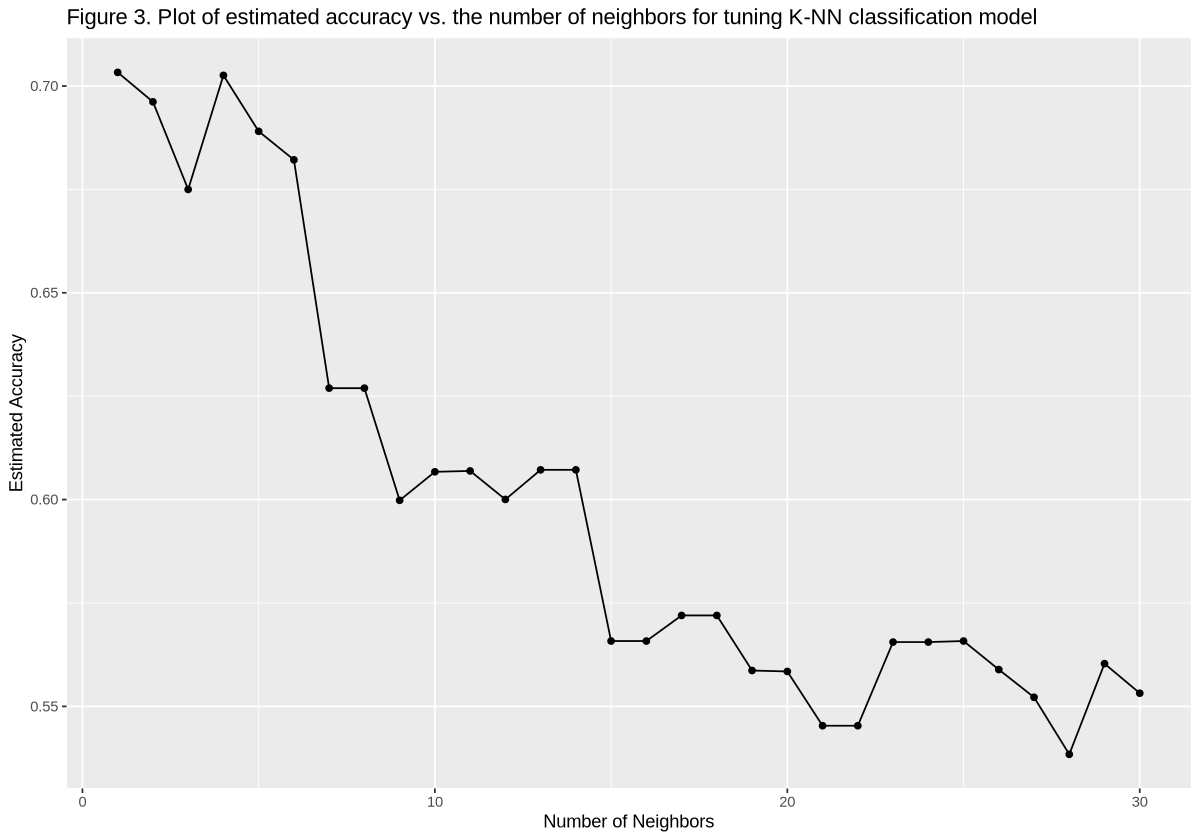

In [10]:
# Plotting estimated accuracy vs. K

options(repr.plot.height=7,repr.plot.width=10)

cross_val_plot<-mc_tune|>
    ggplot(aes(x=neighbors,y=mean))+
    geom_point()+
    geom_line()+
    labs(x="Number of Neighbors",
         y="Estimated Accuracy",
         title="Figure 3. Plot of estimated accuracy vs. the number of neighbors for tuning K-NN classification model")

cross_val_plot

# Choosing K = 5 based on results (high estimated accuracy (EA) and differences in EAs for K=4 and K=6 are not significant)

In [11]:
# Predicting test data using the chosen K of 5

# Creating new model specification with tuned K (5)
tuned_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

# Creating new workflow with the new model specification
mc_fit<-workflow()|>
    add_recipe(mc_recipe)|>
    add_model(tuned_spec)|>
    fit(data=mc_train)

# Predicting test data
mc_predictions<-mc_fit|>
    predict(mc_test)|>
    bind_cols(mc_test)

head(mc_predictions)

.pred_class,avg_session_hours,sessions_played,played_hours,age,subscription_status
<fct>,<dbl>,<int>,<dbl>,<dbl>,<fct>
Not Subscribed,0.30,1,0.2,37,Not Subscribed
Subscribed,0.38,2,0.6,19,Subscribed
Subscribed,0.72,2,1.2,17,Subscribed
Not Subscribed,0.08,1,0.0,26,Not Subscribed
Subscribed,0.18,4,0.3,17,Subscribed
Subscribed,0.15,1,0.1,15,Subscribed


In [12]:
# Computing accuracy
mc_metrics<-mc_predictions|>
    metrics(truth=subscription_status,estimate=.pred_class)|>
    filter(.metric=="accuracy")

mc_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7755102


In [13]:
# Generating confusion matrix
mc_conf_mat<-mc_predictions|>
    conf_mat(truth=subscription_status,estimate=.pred_class)
    
mc_conf_mat

                Truth
Prediction       Subscribed Not Subscribed
  Subscribed             32              7
  Not Subscribed          4              6

In [14]:
# Computing precision and accuracy for both classes

# Numeric values from confusion matrix
TP_subscribed <- 32  # True positives for Subscribed
FP_subscribed <- 7   # False positives for Subscribed
FN_subscribed <- 4   # False negatives for Subscribed
TN_subscribed <- 6   # True negatives for Subscribed

# Compute precision and recall for both classes
precision_subscribed <- round(TP_subscribed / (TP_subscribed + FP_subscribed), 2)
recall_subscribed <- round(TP_subscribed / (TP_subscribed + FN_subscribed), 2)

precision_not_subscribed <- round(TN_subscribed / (TN_subscribed + FN_subscribed), 2)
recall_not_subscribed <- round(TN_subscribed / (TN_subscribed + FP_subscribed), 2)

# Create tibble with precision and recall
mc_precision_recall <- tibble(
  `Class Assumed Positive` = c("Subscribed", "Not Subscribed"),
  Precision = c(precision_subscribed, precision_not_subscribed),
  Recall = c(recall_subscribed, recall_not_subscribed)
)

mc_precision_recall

Class Assumed Positive,Precision,Recall
<chr>,<dbl>,<dbl>
Subscribed,0.82,0.89
Not Subscribed,0.60,0.46


# Visualizing Results

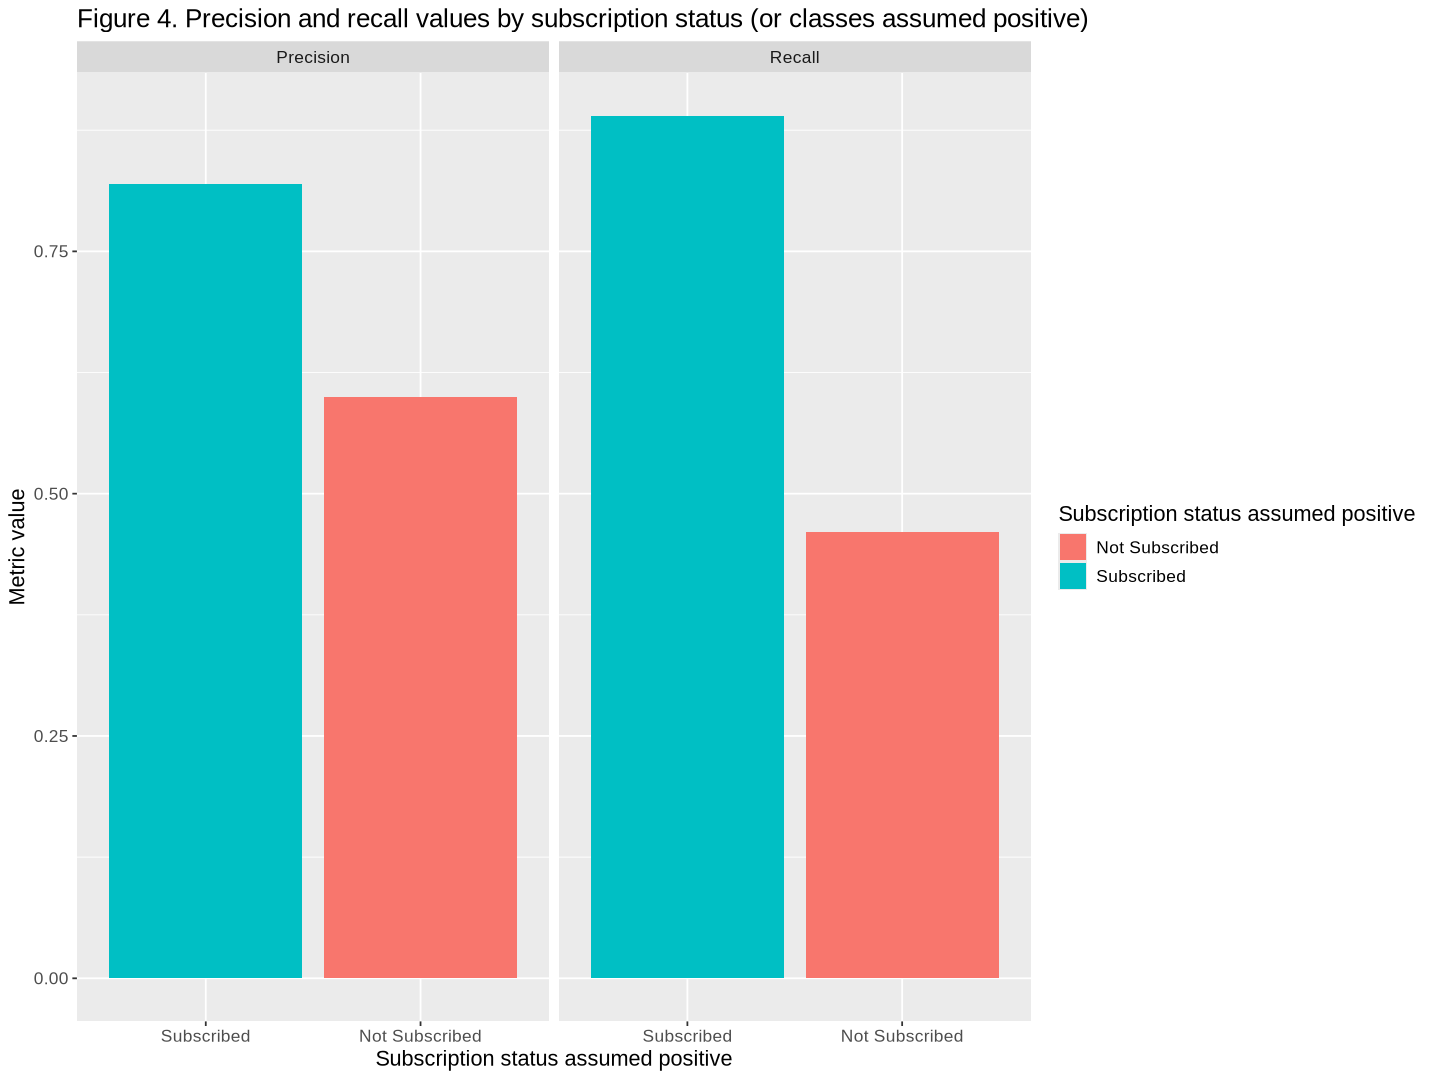

In [15]:
options(repr.plot.width=12,repr.plot.height=9)

# Recall and precision comparison bar chart between subscription statuses

mc_precision_recall_longer<-mc_precision_recall|>
    pivot_longer(cols=Precision:Recall,names_to="metric",values_to="value")

mc_recall_precision_plot<-mc_precision_recall_longer|>
    ggplot(aes(x=fct_reorder(as_factor(`Class Assumed Positive`),value,.desc = TRUE),y=value,fill=`Class Assumed Positive`))+
    geom_bar(stat="identity",position="dodge")+
    facet_grid(cols=vars(metric))+
    labs(x="Subscription status assumed positive",y="Metric value",
         fill="Subscription status assumed positive",
         title="Figure 4. Precision and recall values by subscription status (or classes assumed positive)")+
    theme(text = element_text(size = 13))

mc_recall_precision_plot

# Discussion

**Summary of findings**:

After applying the tuned classification model to the testing data, the accuracy unexpectedly exceeded the estimated accuracy from tuning (77.55% vs. ~69%), which may be attributed to test data being a smaller sample of an already small dataset (25% of 194 observations), introducing more sampling variability and less reliability compared to the training data. However, some findings from the model were expected by us:

1. Predictions for game-related newsletter subscribers (0.89 recall) were more accurate than for non-subscribers (0.46 recall). However, the prediction performance for subscribers still exceeded our expectations despite the lack of variability for all predictors.
2. Upsampling did not improve predictions for non-subscribers because the inherent problem of insufficient non-subscribers data is unresolved.

In conclusion, players' age, number of sessions played, average session played hours, and total hours played can accurately predict subscribers of game-related newsletters but struggle at predicting non-subscribers likely due to insufficient data.

**Impact of findings**:

Since the Minecraft data were intended to develop an advanced AI for virtual environments, the ability to gauge or predict players' gaming behaviour, like their game-related newsletter subscription status, offers key insights to improve the AI (PLAI, 2024). For example, given that our model accurately predicts subscribers, it can improve the AI virtual player's capacity to interact or engage in conversations with different player types. Assuming subscribers of game-related newsletters tend to be more knowledgeable about gaming terminologies and are more experienced with games (supported by the difference in mean played hours in EDA), the AI virtual player can use this knowledge and engage in specific kinds of conversations tailored to the player type they encounter, making them potentially more approachable and "less robotic".

**Future questions**:

However, issues with this model like predicting non-subscribers are still prevalent, leading to many new questions that extend to improving the model and developing further understanding of the overall concepts, such as:

1. How can we reduce the effects of biases and collect more data about non-subscribers?
2. For the context of our research question, we can also ask what exactly causes players to subscribe to game-related newsletters.
    - Once the causal mechanism is identified, how can we effectively entice players to subscribe to game-related newsletters?
3. Which demographic of players would target advertisements for newsletters work best?


# References

*PLAICraft*. (2024). Pacific Laboratory of Artificial Intelligence (PLAI). Retrieved April 2, 2025, from https://plaicraft.ai/